(tespy-part-load)=

# Part load performance in TESPy

In this section we are investigating how operating the heat pump at part load affects the COP in the thermodynamic
model. To do that, we will extend our model from the previous section to integrate the heat source and the heat sink
air and water flow. Then we are investigating, how a specific design of the heat pump affects the operation at 
conditions different from that design state, i.e. when the ambient temperature changes, when the heat production changes
and when both change simultaneously. The results are again fed back to the energy system optimization.

```{tip}
The TESPy documentation provides more information about part load modeling. There are some examples as well as a 
dedicated section in the documentation of the software's modules: [https://tespy.rtfd.io](https://tespy.rtfd.io).
```

## Introduction

In TESPy it is possible to design a process and based on that design predict the part load operation of the overall
system. To do that, component and process information are calculated from the design as a result and then remian 
unchanged in offdesign operation.

For example, the a heat exchanger's heat transfer coefficient can be calculated in the design based on the heat 
transferred and on the temperature levels at the two inlets and the two outlets of the component. Then for part load
prediction, we can make the assumption that this value does not change (or it may follow a specific curve from a lookup
table). This also means, that we reduce the degrees of freedom by one, for example the terminal temperature difference
cannot be controlled anymore. It will be a result of changes in the flow regime at the heat exchanger and the 
assumptions concerning the heat transfer coefficient.

```{note}
A dedicated section in the excursion's chapter will outline the effect of the single part load specifications we are
providing in this example. You can find it {ref}`here <tespy-partload-disection>`.
```

## Preparing the model

First we are goin to prepare our TESPy model. To do that, we will slightly modify our topology according to the figure
below. The overall specifications on heat exchanger temperatude differences, compressor efficiency etc. will remian the
unchanged.

```{figure} /figures/heat_pump_part_load.svg
---
alt: Component based thermodynamic model of the heat pump for part load modeling
name: tespy-heat-pump-part-load-flowsheet
---
Component based thermodynamic model of the heat pump for part load modeling
```

First, we import the `HeatExchanger` class to model the evaporator, the `Condenser` class to model the condenser 
(instead of the `HeatExchangerSimple`) we used in the first model, and finally the `Source` and `Sink` classes to
represent the ambient air in- and outlet as well as the heating system's feed and return flow. We creat instances of
the components and connect them according to the flowsheet.

In [47]:
from tespy.components import Condenser, HeatExchanger, CycleCloser, Compressor, Valve, Source, Sink
from tespy.connections import Connection, Ref
from tespy.networks import Network

wf = "R290"
nwk = Network(fluids=[wf, "air", "Water"], p_unit="bar", T_unit="C", iterinfo=False)

cp = Compressor("compressor")
ev = HeatExchanger("evaporator")
cd = Condenser("condenser")
va = Valve("expansion valve")
cc = CycleCloser("cycle closer")

so1 = Source("ambient air source")
si1 = Sink("ambient air sink")
so2 = Source("heating source")
si2 = Sink("heating sink")

c0 = Connection(va, "out1", cc, "in1", label="0")
c1 = Connection(cc, "out1", ev, "in2", label="1")
c2 = Connection(ev, "out2", cp, "in1", label="2")
c3 = Connection(cp, "out1", cd, "in1", label="3")
c4 = Connection(cd, "out1", va, "in1", label="4")

nwk.add_conns(c0, c1, c2, c3, c4)

c11 = Connection(so1, "out1", ev, "in1", label="11")
c12 = Connection(ev, "out1", si1, "in1", label="12")

c21 = Connection(so2, "out1", cd, "in2", label="21")
c22 = Connection(cd, "out2", si2, "in1", label="22")

nwk.add_conns(c11, c12, c21, c22)

Next step is parametrization again. Initially, we are going to skip the specification of the terminal temperature
difference at the condenser due to numerical instability.

```{tip}
TESPy relies on good starting values for the solver. Since the applications you can model with the software are generic,
it is impossible to provide starting values natively without knowing what is modeled. Generally, providing mass flow,
pressure and enthalpy values lead to more stable convergence than providing, for example isentropic efficiency or
terminal temperature differences. Also when changing working fluids, the convergence behavior may change completely.
Therefore we provide a tutorial on how to build models with stable starting values on the
[TESPy documentation](https://tespy.readthedocs.io/en/main/tutorials.html).
```

In [48]:
# connections
c2.set_attr(T=2)
c4.set_attr(T=40)

# components
Q_design = -10e3
cp.set_attr(eta_s=0.675)
cd.set_attr(Q=Q_design)

# connections
c2.set_attr(fluid={wf: 1, "Water": 0, "air": 0}, x=1.0)
c11.set_attr(fluid={wf: 0, "Water": 0, "air": 1}, p=1.0, T=5)
c12.set_attr(T=Ref(c11, 1, -2))
c21.set_attr(fluid={wf: 0, "Water": 1, "air": 0}, p=3.0, T=30)
c22.set_attr(T=35)

# components
cd.set_attr(pr1=1, pr2=1)
ev.set_attr(pr1=1, pr2=1)

nwk.solve("design")

In the second step we finalize the specification values and rerun the simulation.

In [49]:
ev.set_attr(ttd_l=5)
c2.set_attr(T=None)

cd.set_attr(ttd_u=5)
c4.set_attr(T=None)

nwk.solve("design")

nwk.print_results(colored=False)
nwk.save("design-state")
nwk.save("tmp")


##### RESULTS (CycleCloser) #####
+--------------+------------------+-------------------+
|              |   mass_deviation |   fluid_deviation |
|--------------+------------------+-------------------|
| cycle closer |         0.00e+00 |          0.00e+00 |
+--------------+------------------+-------------------+
##### RESULTS (HeatExchanger) #####
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|            |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| evaporator | -7.73e+03 | 1.30e+03 | 5.94e+00 | 7.00e+00 | 5.00e+00 | 1.00e+00 | 1.00e+00 | 0.00e+00 | 2.52e-06 |
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (Condenser) #####
+-----------+-----------+----------+------

## Design Mode

### Influence of the ambient temperature

In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


temperature_range = np.linspace(-10, 30, 41)
results_temperature = pd.DataFrame(
    index=temperature_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for temperature in temperature_range:

    c11.set_attr(T=temperature)
    nwk.solve("design")

    results_temperature.loc[temperature, "compressor-power"] = cp.P.val
    results_temperature.loc[temperature, "pressure-ratio"] = cp.pr.val
    results_temperature.loc[temperature, "COP"] = abs(cd.Q.val) / cp.P.val

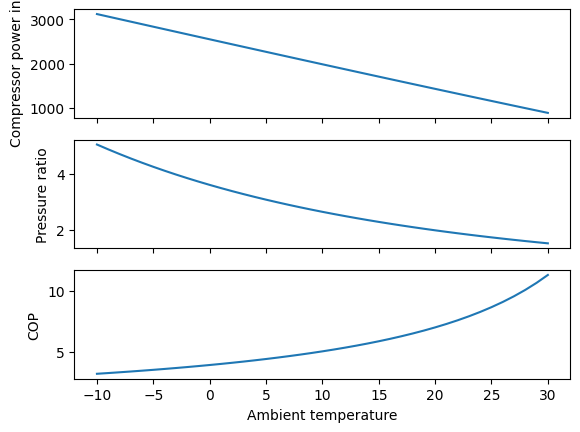

In [51]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(temperature_range, results_temperature["compressor-power"])
ax[1].plot(temperature_range, results_temperature["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
_ = ax[2].set_xlabel("Ambient temperature")


### Influence of the heat production

In [52]:
heat_range = np.linspace(0.5, 1.0, 11) * Q_design
results_heat = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)
T_heat_partload = 5
c11.set_attr(T=T_heat_partload)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("design")

    results_heat.loc[heat, "compressor-power"] = cp.P.val
    results_heat.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

In [53]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"])
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([2, 3])
ax[2].set_ylabel("COP")
ax[2].set_ylim([4, 5])
ax[2].set_xlim([0, np.abs(heat_range).max()])
_ = ax[2].set_xlabel("Consumer heat demand in W")

## Part load simulation

### Influence of the ambient temperature

In [54]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=["eta_s"], offdesign=["eta_s_char"])
cp.eta_s_char.char_func.extrapolate = True
ev.set_attr(design=["ttd_l"], offdesign=["kA_char"])
cd.set_attr(design=["ttd_u"], offdesign=["kA_char"])
c11.set_attr(offdesign=["m"])
c12.set_attr(design=["T"])

# temperature_range = np.linspace(5, -10, 16)

results_temperature_partload = pd.DataFrame(
    index=temperature_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)


for temperature in temperature_range:

    c11.set_attr(T=temperature)
    nwk.solve("offdesign", design_path="design-state")

    results_temperature_partload.loc[temperature, "compressor-power"] = cp.P.val
    results_temperature_partload.loc[temperature, "pressure-ratio"] = cp.pr.val
    results_temperature_partload.loc[temperature, "COP"] = abs(cd.Q.val) / cp.P.val

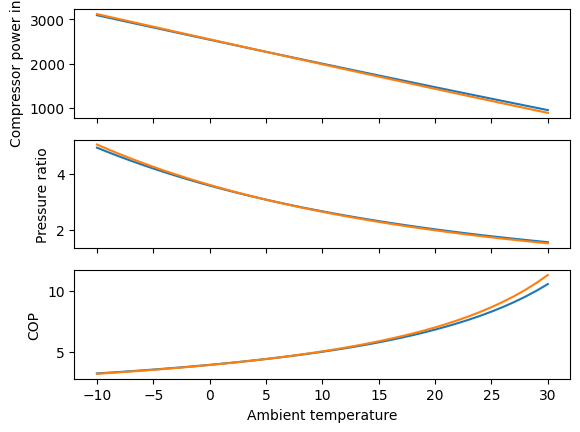

In [55]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(temperature_range, results_temperature_partload["compressor-power"])
ax[1].plot(temperature_range, results_temperature_partload["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature_partload["COP"])

ax[0].plot(temperature_range, results_temperature["compressor-power"])
ax[1].plot(temperature_range, results_temperature["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
_ = ax[2].set_xlabel("Ambient temperature")

```{note}
A way of controlling whether your setup for the part load modeling is correct is to check if offdesign parameter settings of the model lead to the same result as in the design parameter specifications. If these numbers do not align, there might be something wrong the model setup. In this case, we always have the design heat load and we have to compare the results at the design ambient temperature, i.e. 5°C.
```

In [56]:
results_temperature.loc[5]

compressor-power    2265.886404
pressure-ratio         3.069533
COP                    4.413284
Name: 5.0, dtype: object

In [57]:
results_temperature_partload.loc[5]

compressor-power    2265.886404
pressure-ratio         3.069533
COP                    4.413284
Name: 5.0, dtype: object

### Influence of the heat production

In [58]:
c11.set_attr(T=T_heat_partload)
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

Operating point below characteristic line range: X=0.472 with minimum of 0.49 at component compressor.


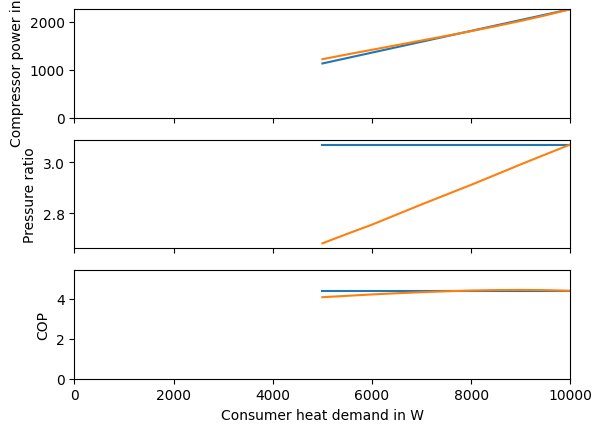

In [67]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max() * 1.05])
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, np.abs(heat_range).max() * 1.05])
_ = ax[2].set_xlabel("Consumer heat demand in W")

We can have the same look at the results from the dataframes. Since we inspected the part load behaviour for the heat output at the design temperature level of the ambient, we should see equal values in the results for the design heat production, i.e. `-10,000.0` W.

In [60]:
results_heat_partload.loc[Q_design]

compressor-power    2265.886404
pressure-ratio         3.069533
COP                    4.413284
Name: -10000.0, dtype: object

In [61]:
results_heat.loc[Q_design]

compressor-power    2265.886404
pressure-ratio         3.069533
COP                    4.413284
Name: -10000.0, dtype: object

## Variable temperature and heat production

In [62]:
temperature_range = [-10, -5, 0, 5, 10, 15, 20]

results = {}


for temperature in temperature_range:
    results[temperature] = pd.DataFrame(index=heat_range, columns=["COP", "compressor-power", "T-evaporation", "T-condensation"])
    c11.set_attr(T=temperature)
    for heat in heat_range[::-1]:
        cd.set_attr(Q=heat)
        if heat == heat_range[-1]:
            nwk.solve("offdesign", design_path="design-state", init_path="tmp")
            nwk.save("tmp")
        else:
            nwk.solve("offdesign", design_path="design-state")  

        results[temperature].loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val
        results[temperature].loc[heat, "compressor-power"] = cp.P.val
        results[temperature].loc[heat, "T-evaporation"] = c2.T.val
        results[temperature].loc[heat, "T-condensation"] = c4.T.val

Operating point below characteristic line range: X=0.486 with minimum of 0.49 at component compressor.
Operating point below characteristic line range: X=0.436 with minimum of 0.49 at component compressor.
Operating point below characteristic line range: X=0.448 with minimum of 0.49 at component compressor.
Operating point below characteristic line range: X=0.46 with minimum of 0.49 at component compressor.
Operating point below characteristic line range: X=0.472 with minimum of 0.49 at component compressor.
Operating point below characteristic line range: X=0.484 with minimum of 0.49 at component compressor.


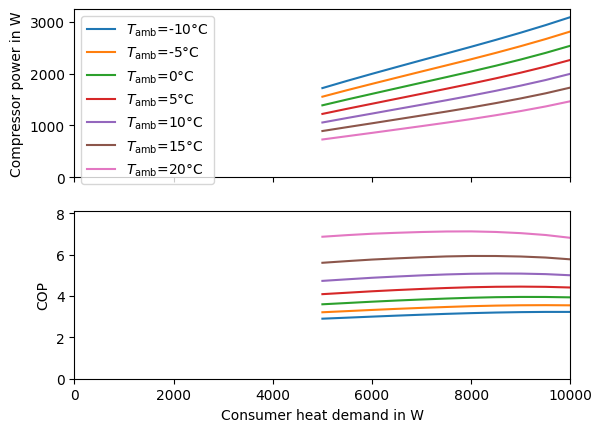

In [63]:
power_max = 0
COP_max = 0

fig, ax = plt.subplots(2, sharex=True)

for temp in temperature_range:

    ax[0].plot(np.abs(results[temp].index), results[temp]["compressor-power"], label="$T_\\mathrm{amb}$=" + str(temp) + "°C")
    ax[1].plot(np.abs(results[temp].index), results[temp]["COP"])
    COP_max = max(results[temp]["COP"].max(), COP_max)
    power_max = max(results[temp]["compressor-power"].max(), power_max)

ax[0].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, power_max * 1.05])
ax[1].set_ylabel("COP")
ax[1].set_ylim([0, COP_max + 1])
ax[1].set_xlim([0, np.abs(heat_range).max() * 1.05])
_ = ax[1].set_xlabel("Consumer heat demand in W")

## Preparing the data for oemof-solph

In [64]:
def least_squares(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    slope, offset = np.linalg.lstsq(A, y, rcond=None)[0]
    return slope, offset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


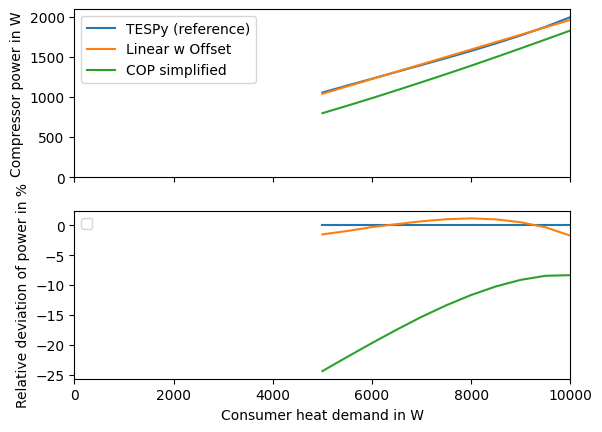

In [65]:
temp = 10

COP_c_simple = (273.15 + 58) / (58 - -10)
eta_c_simple = 0.65

x = -results[temp].index.values.astype(float)
y = results[temp]["compressor-power"].values.astype(float)
yy_tespy = y


COP_c_simple = (results[temp]["T-condensation"] + 273.15) / (results[temp]["T-condensation"] - results[temp]["T-evaporation"])
eta_c_simple = 0.649

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(x, yy_tespy, label="TESPy (reference)")

slope, offset = least_squares(x, y)
yy_offset = offset + slope * x
ax[0].plot(x, yy_offset, label="Linear w Offset")
ax[0].plot(x, x / (COP_c_simple * eta_c_simple), label="COP simplified")

ax[1].plot(x, (yy_tespy - yy_tespy) / yy_tespy * 100)
ax[1].plot(x, (yy_offset - yy_tespy) / yy_tespy * 100)
ax[1].plot(x, (x / (COP_c_simple * eta_c_simple) - yy_tespy) / yy_tespy * 100)

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, y.max() * 1.05])
ax[1].set_ylabel("Relative deviation of power in %")
ax[1].set_xlim([0, x.max() * 1.05])
_ = ax[1].set_xlabel("Consumer heat demand in W")

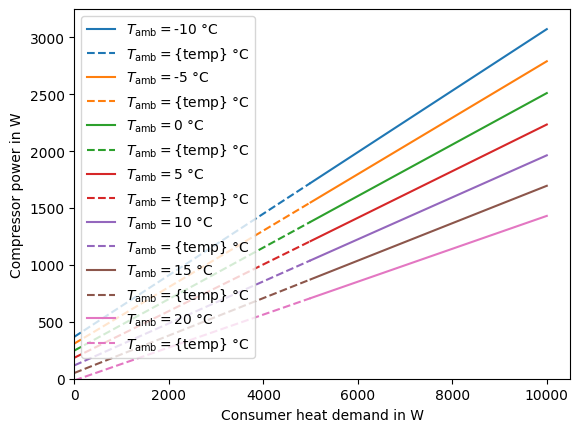

In [72]:

fig, ax = plt.subplots(1, sharex=True)

for temp in temperature_range:
        
    x = -results[temp].index.values.astype(float)
    y = results[temp]["compressor-power"].values.astype(float)
    slope, offset = least_squares(x, y)
    p = ax.plot(x, slope * x + offset, label="$T_\\mathrm{amb}=$" + str(temp) + " °C")  # get line information to extract color
    ax.plot([0, x.min()], slope * np.array([0, x.min()]) + offset, "--", color=p[0].get_color())
    power_max = max(results[temp]["compressor-power"].max(), power_max)

ax.legend()
ax.set_ylim([0, power_max * 1.05])
ax.set_ylabel("Compressor power in W")
ax.set_xlim([0, x.max() * 1.05])
_ = ax.set_xlabel("Consumer heat demand in W")


## Prepare output for solph

For the `OffsetTransformer` we need a slightly different output structure, than provided by the results dictionary with the pandas dataframes for every temperature: The coefficients (offset and slope) for every ambient temperature level are required. We can build a new dataframe, that holds these information and export them into csv format and export those information.


## Slope definition in solph

- heat production as function of compressor power

In [ ]:
export_df = pd.DataFrame(index=temperature_range, columns=["slope", "offset"])

for key, data in results.items():
    y = -data.index.values.astype(float)
    x = data["compressor-power"].values.astype(float)
    export_df.loc[key] = least_squares(x, y)

export_df.to_csv("coefficients-offset-transformer.csv")